In [1]:
from keras.layers import Input, Dense,Dropout
#from keras.layers.core import AutoEncoder
from keras.models import Model,Sequential
#from keras.layers import containers
import numpy as np
import pandas
import os
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD


Using TensorFlow backend.


In [2]:
def process_data(M,N,S_day,L_day,fac_num):
    #区分训练集和测试集,以最后一个换仓日为界
    Ctrain=M[M.Date>S_day]
    C_train=Ctrain[Ctrain.Date<L_day]
    C_test=N[N.Date==L_day]
    name=['Date','Symbol','Return']
    Retu=C_test[name]

    #fac_num=C_data.shape[1]-2
    TrainX=np.array(C_train.iloc[:,2:fac_num+2].values.astype('float32'))
    TestX=np.array(C_test.iloc[:,2:fac_num+2].values.astype('float32')) 
    TrainY=C_train['label'].astype('category')
    TrainY=np.array(TrainY.tolist())
    #TestY=C_test['label'].astype('category')
    #TestY=np.array(TestY.tolist())
    rval=[Retu,(TrainX,TrainY),TestX]
    return  rval


def load_retu(file,C_data,L_day):
    Ret=pandas.read_csv(file,engine='python', skipfooter=3)
    # Y分为两档，换仓期间收益率表现为前20%的为强势股标为1，后20%为弱势标为0
    Y_data=Ret.rename(columns={'tdate': 'Date','symbol':'Symbol'})
    #print(len(C_data))
    #print(Y_data.head())
    M=pandas.merge(C_data,Y_data,how='inner',on=['Date','Symbol'])
    #print(M.head())
    #print(len(M))
    
    #区分训练集和测试集,以最后一个换仓日为界
    lastday=split_date(L_day)
    C_train=M[M.Date<int(lastday)]
    C_test=M[M.Date==int(lastday)]
    #print(C_test)
    fac_num=C_data.shape[1]-2
    TrainX=np.array(C_train.iloc[:,2:fac_num+2].values.astype('float32'))
    TestX=np.array(C_test.iloc[:,2:fac_num+2].values.astype('float32')) 
    TrainY=C_train['label'].astype('category')
    TrainY=np.array(TrainY.tolist())
    TestY=C_test['label'].astype('category')
    TestY=np.array(TestY.tolist())
    rval=[(TrainX,TrainY),(TestX,TestY)]
    return rval

def neural_network(dim,nb_cl,loss='categorical_crossentropy', optimizer='adadelta'):
    ######神经网络结构搭建
    encoding_dim = dim[-1]
    model=Sequential()
    model.add(Dense(input_dim=dim[0],output_dim=dim[1],activation='relu'))
    model.add(Dropout(.25))
    model.add(Dense(input_dim=dim[1],output_dim=dim[2],activation='relu'))
    model.add(Dropout(.25))
    model.add(Dense(input_dim=dim[2],output_dim=dim[3],activation='relu'))
    model.add(Dropout(.25))
    model.add(Dense(input_dim=dim[3],output_dim=nb_cl,activation='softmax'))#只看换仓日当天压缩后的factor
    #print(classifier.layers)
    #lr=.05
    #decay=1e-6
    #momentum=.9
    #model.add(Dense(input_dim=encoding_dim,output_dim=8,init='normal',activation='tanh'))
    #sgd = SGD(lr, decay, momentum, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer='adadelta',metrics=['accuracy'])
    return model

def backtest(Retu):
    name1=['Date','Symbol','Return','proba1']
    Ret1=Retu[name1]
    name2=['Date','Symbol','Return','proba0']
    Ret2=Retu[name2]

    long=Ret1.sort(columns=['proba1'],ascending=False)[0:100]
    short=Ret2.sort(columns=['proba0'],ascending=False)[0:100]
    
    long50=Ret1.sort(columns=['proba1'],ascending=False)[0:50]
    short50=Ret2.sort(columns=['proba0'],ascending=False)[0:50]
    alpha=np.mean(long['Return'])-np.mean(short['Return'])
    print("\n alpha of long/short first 100 is  %.2f%%" % (alpha*100))
    print("\n long return is %.2f%%" % (np.mean(long['Return'])*100))
    print("\n short return is %.2f%%" % (np.mean(short['Return'])*100))
    
    long100=np.mean(long['Return'])
    short100=np.mean(short['Return'])
    #print(long50)
    #print(short50)
    #alpha_sh=np.mean(long['Return'])-(-0.0487)
    #print("\n alpha to sh300 is  %.2f%%" % (alpha_sh*100))

    alpha50=np.mean(long50['Return'])-np.mean(short50['Return'])
    print("\n alpha of long/short first 50 is  %.2f%%" % (alpha50*100))
    print("\n long return is %.2f%%" % (np.mean(long50['Return'])*100))
    print("\n short return is %.2f%%" % (np.mean(short50['Return'])*100))

    return alpha,alpha50,long100,short100

In [34]:
if __name__=='__main__':  
    ###导入全历史因子训练数据
    path1='/home/jovyan/work/'
    os.chdir(path1)
    FacData = pandas.read_csv('Train1.csv',engine='python')
    FacData2 = pandas.read_csv('Train2.csv',engine='python')
    FacData3 = pandas.read_csv('Train3.csv',engine='python')
    #FacData4 =  pandas.read_csv('train4.csv',engine='python', skipfooter=3)  
   

    FacData=FacData.append(FacData2)
    FacData=FacData.append(FacData3)
    #FacData=FacData.append(FacData4)
    
    ####换仓日列表
    AdDay=pandas.read_csv('adjustDay.csv',engine='python',skipfooter=3)           
    DayList=np.array(AdDay['Start']).astype(str)
    print(len(DayList))
    #Period=22      #持仓期间22天

    #####导入历史股票分档数据，持仓期间收益表现前30%标为1，后30%标为0######
    Label=pandas.read_csv('Label2.csv',engine='python')
    Y_data=Label.rename(columns={'tdate': 'Date','symbol':'Symbol'})
    
    #将标签数据与因子数据合成训练数据
    TrainData=pandas.merge(FacData,Y_data,how='inner',on=['Date','Symbol'])
    print("训练数据长度: "+str(len(TrainData)))
    #dataframe = pandas.read_csv("inte.csv",usecols=[1], engine='python', skipfooter=3)
    fac_num=FacData.shape[1]-2
    print("Factor个数为："+str(fac_num))
    #FacData.head()

    #将持仓期间全市场股票收益率与换仓日因子数据合成测试数据集，每次测试只看换仓日当天数据，无标签数据
    Ret_all=pandas.read_csv('Return.csv',engine='python')
    Ret_all=Ret_all.rename(columns={'tdate': 'Date','symbol':'Symbol'})
    TestData=pandas.merge(FacData,Ret_all,how='inner',on=['Date','Symbol'])
    len(TestData)
    
    np.random.seed(123)
    #####Parameter
    nb_cl=2#####输出股票分组个数
    dim=[fac_num,100,100,100]
    #print(os.getcwd())
    path2='/home/jovyan/work/backtest_dnn/21 factor test/'
    os.chdir(path2)

#(len(DayList)-12*3-2)

    alpha100=[]
    alpha50=[]
    testIC=[]
    testDate=[]
    long100=[]
    short100=[]
   

    np.random.seed(123)
    for i in range(45,len(DayList)-12*3-2):
        S_day=DayList[i]#滚动回测期间第一个换仓日
        L_day=DayList[i+3*12+1] #滚动回测期间最后一个换仓日，预测日
        
        Sday=int(S_day)-1
        Lday=int(L_day)
        testDate.append(Lday)
        print("起始时间："+str(S_day))
        print("换仓日： "+str(L_day))
        ###构建滚动回测窗口，用三年期训练数据集有监督训练整个神经网络
        ###换仓日当天因子数据作为测试数据预测下一期股票分类

        Retu,(x_train,y_train),x_test=process_data(TrainData,TestData,Sday,Lday,fac_num)
        Train_Y= np_utils.to_categorical(y_train, nb_cl)   ###将训练标签转换成kera适应的categorical形式
        #Test_Y=np_utils.to_categorical(y_test, nb_cl)
        print(x_test.shape)
        #Train_Y[0:50]

        model=neural_network(dim,nb_cl,loss='categorical_crossentropy', optimizer='adadelta')   

    #####用窗口期间历史因子训练整张网络########
        early_stopping=EarlyStopping(monitor='val_loss', patience=2)
        model.fit(x_train, Train_Y,
                    nb_epoch=100,
                    batch_size=1000,
                    shuffle=True,
                    validation_split=.2,callbacks=[early_stopping])
        
        
        train_score=model.evaluate(x_train[.8*len(x_train):len(x_train)],
                               Train_Y[.8*len(x_train):len(x_train)],batch_size=1000)
        print("Train_score is: "+str(train_score))
        classes = model.predict_classes(x_train)
        proba = model.predict_proba(x_train)
        accuracy = np.mean(classes==y_train)
        print("\n Training Accuracy: %.2f%%" % (accuracy*100))  
        #predictions = [float(round(x)) for x in list(probabilities)]
        accuracy = np.sum([1 for m,k in zip(classes,y_train) if k==m==0])/np.sum([1 for k in y_train if k==0])
        print("\n Training 0-class Accuracy: %.2f%%" % (accuracy*100))
        accuracy = np.sum([1 for m,k in zip(classes,y_train) if k==m==1])/np.sum([1 for k in y_train if k==1])
        print("\n Training 1-class Accuracy: %.2f%%" % (accuracy*100))
        ####在测试集上做预测，输出股票分类和概率
        
        classes2 = model.predict_classes(x_test)
        proba2 = model.predict_proba(x_test)
        #print(proba2[0:50])
        #print(classes2[0:50])
        pred1=proba2[:,1]
        pred0=proba2[:,0]
        Retu['proba1']=pred1
        Retu['proba0']=pred0
        print ('\n test IC:',np.corrcoef(pred1,Retu['Return'])[0][1])
        testIC.append(np.corrcoef(pred1,Retu['Return'])[0][1])
        #print(pred0)
        Retu.to_csv(path2+'long_cnn '+ str(Lday) +'.csv')
        #print(Retu)
        alpha1,alpha2,long,short=backtest(Retu)
        alpha100.append(alpha1)
        alpha50.append(alpha2)
        long100.append(long)
        short100.append(short)
    ###end of loop
      

        #print(alpha100)
        #print(testIC)

起始时间：20110908
换仓日： 20140930
(2381, 21)
Train on 40387 samples, validate on 10097 samples
Epoch 1/100
40387/40387 [==============================] - 3s - loss: 0.6989 - acc: 0.5217 - val_loss: 0.6829 - val_acc: 0.5712
Epoch 2/100
40387/40387 [==============================] - 0s - loss: 0.6933 - acc: 0.5309 - val_loss: 0.6809 - val_acc: 0.5783
Epoch 3/100
40387/40387 [==============================] - 0s - loss: 0.6894 - acc: 0.5408 - val_loss: 0.6796 - val_acc: 0.5808
Epoch 4/100
40387/40387 [==============================] - 0s - loss: 0.6887 - acc: 0.5425 - val_loss: 0.6811 - val_acc: 0.5780
Epoch 5/100
40387/40387 [==============================] - 0s - loss: 0.6864 - acc: 0.5445 - val_loss: 0.6805 - val_acc: 0.5732
Epoch 6/100
2240/2381 [===========================>..] - ETA: 0s
 test IC: 0.0518866561345

 alpha of long/short first 100 is  3.26%

 long return is 5.26%

 short return is 2.01%

 alpha of long/short first 50 is  1.74%

 long return is 3.49%

 short return is 1.75%
起始时

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:71: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:72: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:74: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:75: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Train on 40528 samples, validate on 10132 samples
Epoch 1/100
40528/40528 [==============================] - 3s - loss: 0.6992 - acc: 0.5177 - val_loss: 0.6841 - val_acc: 0.5721
Epoch 2/100
40528/40528 [==============================] - 0s - loss: 0.6923 - acc: 0.5305 - val_loss: 0.6815 - val_acc: 0.5698
Epoch 3/100
40528/40528 [==============================] - 0s - loss: 0.6895 - acc: 0.5381 - val_loss: 0.6806 - val_acc: 0.5692
Epoch 4/100
40528/40528 [==============================] - 0s - loss: 0.6870 - acc: 0.5428 - val_loss: 0.6789 - val_acc: 0.5710
Epoch 5/100
40528/40528 [==============================] - 0s - loss: 0.6867 - acc: 0.5470 - val_loss: 0.6801 - val_acc: 0.5719
Epoch 6/100
40528/40528 [==============================] - 0s - loss: 0.6859 - acc: 0.5466 - val_loss: 0.6790 - val_acc: 0.5722
Epoch 7/100
40528/40528 [==============================] - 0s - loss: 0.6848 - acc: 0.5497 - val_loss: 0.6783 - val_acc: 0.5749
Epoch 8/100
40528/40528 [=============================

7.886490793463007


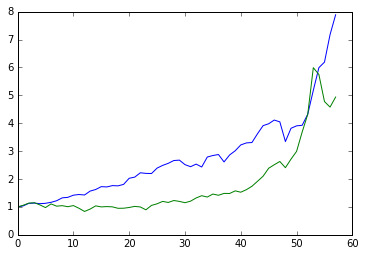

In [29]:
######Plot Cummulative NAV#######

def nav(y):
    nav=[1]
    for k in range(len(y)):
        nav.append(nav[k]*(1+y[k]))
    return nav

nav_alpha=nav(alpha100)
nav_long=nav(long100)
    

plt.plot(nav_alpha,color='blue',label='alpha')
plt.plot(nav_long,color='green',label='long')
print(nav_alpha[-1])

In [30]:
from bokeh.plotting import figure, output_notebook, show,output_file
from math import pi
output_notebook()

p = figure(plot_width=900, plot_height=400)

p.title = "Alpha NAV of long/short by DNN"
p.xaxis.major_label_orientation = pi/4
p.grid.grid_line_alpha=0.3
index=[i for i in range(len(testDate))]
#tY_exp=dataset[train_size:len(dataset)]
#testP=convert(testPredict)
#print(testP)
#print(testPredict)
#int(testP)
#testY=testY
#print(dataO,trainpredict,testpredict)
#p.line(x=index,y=dataO, color="blue")
p.line(x=index,y=nav_alpha,color="blue",legend="alpha100")
p.line(x=index, y=nav_long,color="orange",legend="alpha50")
show(p)

Loading BokehJS ...

In [36]:
show(p)